In [3]:
# Import statements - run this cell first
import json
import numpy as np
import requests
import os
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import re
from scipy.stats import anderson
from dotenv import load_dotenv
import datetime
load_dotenv()

/Users/alexc/Desktop/UofG/Final_Project/FinalProject/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


True

In [66]:
# Get the distribution of the github repositories by the number of commits
# Only consider Java repositories with 1000+ stars
# Only count the number of commits for the default branch
        # https://gist.github.com/0penBrain/7be59a48aba778c955d992aa69e524c5 - curl command to get the number of commits for the default branch
        # https://stackoverflow.com/questions/37602893/github-search-limit-results - way to go around the 1000 results limit on the github api

def get_top_java_repositories(repositories_dict=None, starsFrom=1000):     
    if repositories_dict is None:
        repositories_dict = {}

    try:
        total_count = 10000
        while total_count > 1: # Github api only allows 1000 results, regardless of the number of pages => need to add created from date to get all of them
            page = 1
            while (page - 1) * 100 < total_count and page < 11: # 1000 results limit
                # Make request to search for Java repositories with 1000+ stars
                print(f"GIT API Request with stars from: {starsFrom}")
                req = f'https://api.github.com/search/repositories?q=language:java stars:>={starsFrom}&per_page=100&sort=stars&order=asc&page={page}'
                print(req)
                response = requests.get(req, headers={'Authorization': f'Bearer {os.getenv("GITHUB_API_KEY")}'})
                response.raise_for_status()
                
                data = response.json()
                total_count = data['total_count']
                repositories = data['items']

                # Iterate through each repository on the page and create a dictionary entry for it if its not present
                for repo in repositories:
                    if repo['id'] in repositories_dict:
                        print(repositories_dict[repo['id']]['created_at'], repositories_dict[repo['id']]['stars'])
                        continue
                    repositories_dict[repo['id']] = {
                        'name': repo['name'],
                        'owner': repo['owner']['login'],
                        'created_at': repo['created_at'],
                        'stars' : repo['stargazers_count']
                    }
                    print(f"Repository added: {repo['id']}, Name: {repo['name']}, Owner: {repo['owner']['login']}")

                maxStars = repositories[-1]['watchers']
                print(f"Page {page} done")
                page += 1
            starsFrom = maxStars
            print(f"Inner while done; Total count: {total_count}, Max stars: {starsFrom}")
    except requests.exceptions.RequestException as e:
        print("Error:", e)
    
    print("All repositories done; Total count:", len(repositories_dict))
    return repositories_dict, starsFrom

# loop throught the pages and get the commits
def populate_repositories_with_commits(repositories_dict):
    try:
        for repo in repositories_dict:
            if 'commitCount' in repositories_dict[repo]:
                continue
            owner = repositories_dict[repo]['owner']
            repo_name = repositories_dict[repo]['name']
            commits_url = f"https://api.github.com/repos/{owner}/{repo_name}/commits?per_page=1"

            # Make request to get commits for the repository
            commits_response = requests.get(commits_url, headers={'Authorization': f'Bearer {os.getenv("GITHUB_API_KEY")}'})
            commits_response.raise_for_status()

            # Extract page number from Link header
            link_header = commits_response.headers.get('Link', '')
            commit_count = extract_commit_count(link_header)
            repositories_dict[repo]['commitCount'] = commit_count
            print(f"Repository: {repo_name}, Owner: {owner}, Commit Count: {commit_count}")
        return repositories_dict
    except requests.exceptions.RequestException as e:
        print("Error:", e)
        return repositories_dict

def extract_commit_count(link_header):
    # Extracts the page number from the Link header using regex
    try:
        match = re.search(r'&page=(\d+)>; rel="last"', link_header)
        if match:
            return int(match.group(1))
    except AttributeError:
        return None
    return None

In [5]:
# get the repositories
def get_high_star_repositories():
    repositories_all = {}
    if os.path.exists('high_star_repositories.json'):
        with open('high_star_repositories.json', 'r') as json_file:
            repositories_all = json.load(json_file)
    else:
        repositories_all, max_stars = get_top_java_repositories()
        with open('high_star_repositories.json', 'w') as json_file:
            json.dump(repositories_all, json_file, indent=4)
    return repositories_all

# get the repositories with commit count
def get_high_star_repositories_with_commitCount():
    repositories_with_commitCount = {}
    if os.path.exists('high_star_repositories_with_commitCount.json'):
        with open('high_star_repositories_with_commitCount.json', 'r') as json_file:
            repositories_with_commitCount = json.load(json_file)
    else:
        repositories = get_high_star_repositories()
        repositories_with_commitCount = populate_repositories_with_commits(repositories)
        with open('high_star_repositories_with_commitCount.json', 'w') as json_file:
            json.dump(repositories_with_commitCount, json_file, indent=4)
    return repositories_with_commitCount

In [6]:
populated_repos = get_high_star_repositories_with_commitCount()

In [7]:
list_of_repos = list(populated_repos.values())

# repos by created at date
repos_by_date = sorted(list_of_repos, key=lambda x: datetime.datetime.strptime(x['created_at'],"%Y-%m-%dT%H:%M:%SZ"), reverse=True)

# repos by stars
repos_by_stars = sorted(list_of_repos, key=lambda x: x['stars'], reverse=True)

# repos by commit count
repos_by_commit_count = sorted(list_of_repos, key=lambda x: x['commitCount'], reverse=True)

In [70]:
for i in range(10):
    print(repos_by_date[i]["created_at"])

2024-01-19T17:28:45Z
2023-12-28T09:13:24Z
2023-12-08T06:06:09Z
2023-11-27T06:25:36Z
2023-11-17T11:37:37Z
2023-10-27T17:17:42Z
2023-10-17T05:49:52Z
2023-09-20T06:41:55Z
2023-09-15T06:42:44Z
2023-08-25T01:45:20Z


In [38]:
# get only the repostiories with commit count > 10000
repos_by_commit_count_10000 = [repo for repo in repos_by_commit_count if repo['commitCount'] > 10000]
repos_by_stars_10000 = [repo for repo in repos_by_stars if repo['stars'] > 10000]
len(repos_by_stars_10000)


216

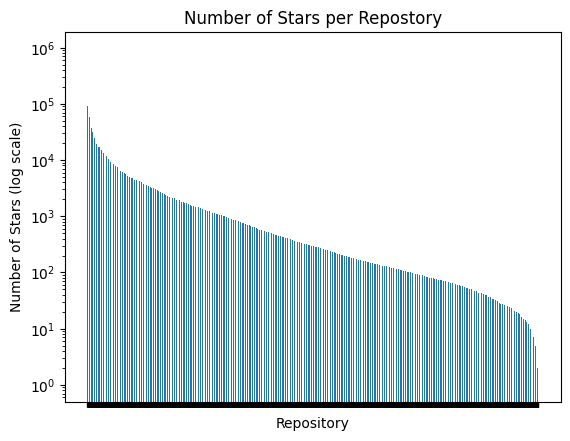

Number of repositories with 1000+ stars: 3405


In [72]:
# Plot the distribution of repositories by stars
repos = [x['name'] for x in repos_by_stars]
stars = [x['commitCount'] for x in repos_by_commit_count]

fig, ax = plt.subplots()
ax.bar(repos, stars, width=0.5)

ax.set(xticklabels=[])
ax.set(xlabel=None)
ax.set(yscale='log')

ax.set_xlabel('Repository')
ax.set_ylabel('Number of Stars (log scale)')
ax.set_title('Number of Stars per Repostory')

plt.show()
print("Number of repositories with 1000+ stars:", len(repos_by_stars))

In [50]:
# To decide on bin number I used the Anderson-Darling test to check
# how normally distributed the data is.

# Perform the Anderson-Darling test
result = anderson(stars)

# Print the test statistic and critical values for different significance levels
print('Anderson-Darling test statistic: %.3f' % result.statistic)
print('Critical values (significance levels):')
for i, crit_val in enumerate(result.critical_values):
    print('%.2f: %.3f' % ((i+1)/len(result.critical_values), crit_val))

# Interpret the results
if result.statistic > result.critical_values[2]:
    print('The data is not normally distributed at the 95% significance level.')
else:
    print('The data is normally distributed at the 95% significance level.')

print(result.statistic)
print(result.critical_values[2])

Anderson-Darling test statistic: 591.065
Critical values (significance levels):
0.20: 0.575
0.40: 0.655
0.60: 0.786
0.80: 0.917
1.00: 1.091
The data is not normally distributed at the 95% significance level.
591.0647096310349
0.786


Bin 1 value range: [1000.00, 7644.00]
Bin 2 value range: [7644.00, 14288.00]
Bin 3 value range: [14288.00, 20932.00]
Bin 4 value range: [20932.00, 27576.00]
Bin 5 value range: [27576.00, 34220.00]
Bin 6 value range: [34220.00, 40863.00]
Bin 7 value range: [40863.00, 47507.00]
Bin 8 value range: [47507.00, 54151.00]
Bin 9 value range: [54151.00, 60795.00]
Bin 10 value range: [60795.00, 67439.00]
Bin 11 value range: [67439.00, 74083.00]
Bin 12 value range: [74083.00, 80727.00]
Bin 13 value range: [80727.00, 87371.00]
Bin 14 value range: [87371.00, 94015.00]
Bin 15 value range: [94015.00, 100659.00]
Bin 16 value range: [100659.00, 107302.00]
Bin 17 value range: [107302.00, 113946.00]
Bin 18 value range: [113946.00, 120590.00]
Bin 19 value range: [120590.00, 127234.00]
Bin 20 value range: [127234.00, 133878.00]
Bin 21 value range: [133878.00, 140522.00]


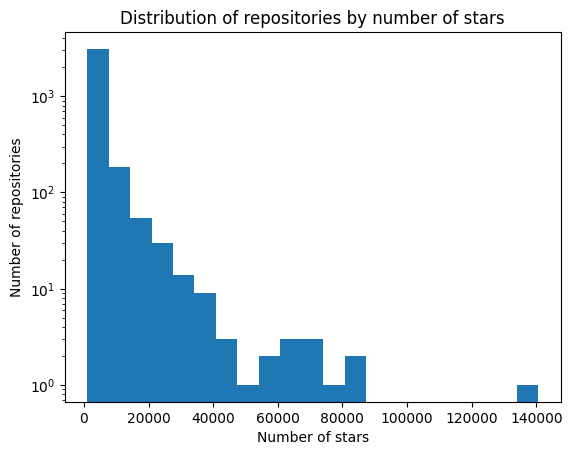

In [52]:
# Calculate the optimal number of bins using the Doane rule -
# which is good for non-normally distributed data.
# Also bin number isnt too high so not many empty bins
values = stars
bin_edges = np.histogram_bin_edges(values, bins='doane')

#Round to nearest int
bin_edges = np.round(bin_edges).astype(int)

# Calculate the histogram
hist, _ = np.histogram(values, bins=bin_edges)

# Print the value ranges of each bin
for i in range(len(bin_edges)-1):
    print(f"Bin {i+1} value range: [{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}]")

# Plot the histogram
import matplotlib.pyplot as plt

plt.hist(values, bins=bin_edges)

# Label the axes
plt.xlabel('Number of stars')
plt.ylabel('Number of repositories')
plt.title('Distribution of repositories by number of stars')
plt.yscale('log')

plt.show()

In [73]:
population = len(repos_by_stars)

# Confidence level of 90%
z_score = 1.645

# Margin of Error of 10%
e = 0.1

# Initial sample size calculation
n = ((z_score**2) * 0.5 * (1-0.5))/e**2

# Sample size given population size
sample_size = math.ceil((population * n)/(population + n))

print("Representative Sample size: ", sample_size)

Representative Sample size:  67


In [60]:
# Calculate percentage of repositories in each bin
bin_ranges = [(bin_edges[i], bin_edges[i+1]) for i in range(len(bin_edges)-1)]
range_counts = [0] * len(bin_ranges)

for count in stars:
    for i, (start, end) in enumerate(bin_ranges):
        if start <= count <= end:
            range_counts[i] += 1
            break
percentages = []          
total_prs = sum(range_counts)
for (start, end), count in zip(bin_ranges, range_counts):
    percentage = count / total_prs * 100
    percentages.append(percentage)
    print(f"Users with {start}-{end} comments: {percentage:.2f}%")

percentages = [round(x, 2) for x in percentages]

Users with 1000-7644 comments: 90.95%
Users with 7644-14288 comments: 5.43%
Users with 14288-20932 comments: 1.59%
Users with 20932-27576 comments: 0.88%
Users with 27576-34220 comments: 0.41%
Users with 34220-40863 comments: 0.26%
Users with 40863-47507 comments: 0.09%
Users with 47507-54151 comments: 0.03%
Users with 54151-60795 comments: 0.06%
Users with 60795-67439 comments: 0.09%
Users with 67439-74083 comments: 0.09%
Users with 74083-80727 comments: 0.03%
Users with 80727-87371 comments: 0.06%
Users with 87371-94015 comments: 0.00%
Users with 94015-100659 comments: 0.00%
Users with 100659-107302 comments: 0.00%
Users with 107302-113946 comments: 0.00%
Users with 113946-120590 comments: 0.00%
Users with 120590-127234 comments: 0.00%
Users with 127234-133878 comments: 0.00%
Users with 133878-140522 comments: 0.03%


In [68]:
# Calculate the frequencies
frequencies = [round(p * sample_size / 100) for p in percentages]

# Sample the PR IDs for each comment range
sampled_repos = []
for freq, (min_stars, max_stars) in zip(frequencies, bin_ranges):
    prs_in_range = [repos[i] for i in range(len(repos)) if min_stars <= stars[i] <= max_stars]
    if len(prs_in_range) < freq:
        # Not enough PRs in range, add all of them
        sampled_repos.extend(prs_in_range)
    else:
        # Enough PRs in range, sample randomly
        sampled_repos.extend(random.sample(prs_in_range, freq))

# Shuffle the PR IDs to mix up the comment ranges
random.shuffle(sampled_repos)


In [69]:
print(sampled_repos)

# Get the number of commits for each sampled repository
commit_counts = [ ]
for repo in sampled_repos:
    commit_counts.append()

['jna', 'incubator-paimon', 'BlockHound', 'carouselview', 'Document', 'zeppelin', 'Taurus', 'dubbo-admin', 'sonarqube-community-branch-plugin', 'viro', 'vueblog', 'vectalign', 'metasfresh', 'HTTPDNSLib', 'angel', 'HotswapAgent', 'remote-desktop-clients', 'eureka', 'MVCHelper', 'fresco', 'seldon-server', 'Android-BLE', 'nlp-lang', 'secure-preferences', 'springdoc-openapi', 'ReadMoreTextView', 'MarqueeView', 'Activiti', 'discreteSeekBar', 'Openfire', 't-digest', 'RecyclerViewUndoSwipe', 'AsciidocFX', 's3proxy', 'manifold', 'ViewServer', 'ListViewAnimations', 'SortableTableView', 'FadingActionBar', 'jutils', 'auto', 'VCameraDemo', 'dsl', 'thinking-in-spring-boot-samples', 'AnimatorDurationTile', 'My-Blog', 'androidtv-Leanback', 'okdownload', 'jbot', 'AxonFramework', 'awaitility', 'material', 'spring-boot-tutorial', 'radar', 'webporter', 'PowerMenu', 'java-basics', 'thymeleaf', 'CityPicker', 'airsonic', 'toBeTopJavaer', 'word', 'odd-platform', 'itchat4j', 'android-ripple-background', 'Burp

# Commentors example



In [55]:
# To decide on bin number I used the Anderson-Darling test to check
# how normally distributed the data is.

# Extract the comment numbers from your dictionary
comment_numbers = list(commenters_dict.values())

# Perform the Anderson-Darling test
result = anderson(comment_numbers)

# Print the test statistic and critical values for different significance levels
print('Anderson-Darling test statistic: %.3f' % result.statistic)
print('Critical values (significance levels):')
for i, crit_val in enumerate(result.critical_values):
    print('%.2f: %.3f' % ((i+1)/len(result.critical_values), crit_val))

# Interpret the results
if result.statistic > result.critical_values[2]:
    print('The data is not normally distributed at the 95% significance level.')
else:
    print('The data is normally distributed at the 95% significance level.')

Anderson-Darling test statistic: 268.714
Critical values (significance levels):
0.20: 0.575
0.40: 0.654
0.60: 0.785
0.80: 0.916
1.00: 1.089
The data is not normally distributed at the 95% significance level.


Bin 1 value range: [1.00, 333.00]
Bin 2 value range: [333.00, 665.00]
Bin 3 value range: [665.00, 997.00]
Bin 4 value range: [997.00, 1329.00]
Bin 5 value range: [1329.00, 1661.00]
Bin 6 value range: [1661.00, 1993.00]
Bin 7 value range: [1993.00, 2325.00]
Bin 8 value range: [2325.00, 2657.00]
Bin 9 value range: [2657.00, 2989.00]
Bin 10 value range: [2989.00, 3321.00]
Bin 11 value range: [3321.00, 3652.00]
Bin 12 value range: [3652.00, 3984.00]
Bin 13 value range: [3984.00, 4316.00]
Bin 14 value range: [4316.00, 4648.00]
Bin 15 value range: [4648.00, 4980.00]
Bin 16 value range: [4980.00, 5312.00]
Bin 17 value range: [5312.00, 5644.00]
Bin 18 value range: [5644.00, 5976.00]
Bin 19 value range: [5976.00, 6308.00]
Bin 20 value range: [6308.00, 6640.00]
Bin 21 value range: [6640.00, 6972.00]


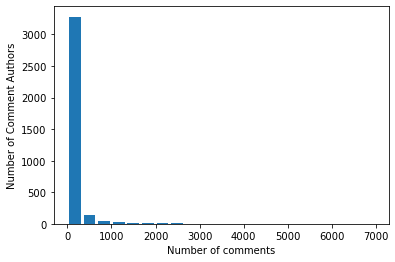

In [56]:
# Calculate the optimal number of bins using the Doane rule -
# which is good for non-normally distributed data.
# Also bin number isnt too high so not many empty bins
bin_edges = np.histogram_bin_edges(values, bins='doane')

#Round to nearest int
bin_edges = np.round(bin_edges).astype(int)

# Calculate the histogram
hist, _ = np.histogram(values, bins=bin_edges)

# Print the value ranges of each bin
for i in range(len(bin_edges)-1):
    print(f"Bin {i+1} value range: [{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}]")

# Plot the histogram
import matplotlib.pyplot as plt

plt.hist(values, bins=bin_edges, rwidth=0.8)

# Label the axes
plt.xlabel('Number of comments')
plt.ylabel('Number of Comment Authors')

plt.show()

In [57]:
population = 3186

# Confidence level of 95%
z_score = 1.96

# Margin of Error of 10%
e = 0.1

# Initial sample size calculation
n = ((z_score**2) * 0.5 * (1-0.5))/e**2

# Sample size given population size
sample_size = math.ceil((population * n)/(population + n))

print("Representative Sample size: ", sample_size)

Representative Sample size:  94


In [58]:
ranges = [(10.0, 333.0),
          (333.0, 665.0),
          (665.0, 997.0),
          (997.0, 1329.0),
          (1329.0, 1661.0),
          (1661.0, 1993.0),
          (1993.0, 2325.0),
          (2325.0, 2657.0),
          (2657.0, 2989.0),
          (2989.0, 3321.0),
          (3321.0, 3652.0),
          (3652.0, 3984.0),
          (3984.0, 4316.0),
          (4316.0, 4648.0),
          (4648.0, 4980.0),
          (4980.0, 5312.0),
          (5312.0, 5644.0),
          (5644.0, 5976.0),
          (5976.0, 6308.0),
          (6308.0, 6640.0),
          (6640.0, 6972.0)]

In [59]:
range_counts = [0] * len(ranges)

for count in commenters_dict.values():
    for i, (start, end) in enumerate(ranges):
        if start <= count <= end:
            range_counts[i] += 1
            break
percentages = []          
total_prs = sum(range_counts)
for (start, end), count in zip(ranges, range_counts):
    percentage = count / total_prs * 100
    percentages.append(percentage)
    print(f"Users with {start}-{end} comments: {percentage:.2f}%")

percentages = [round(x, 2) for x in percentages]

Users with 10.0-333.0 comments: 83.96%
Users with 333.0-665.0 comments: 8.90%
Users with 665.0-997.0 comments: 2.99%
Users with 997.0-1329.0 comments: 1.43%
Users with 1329.0-1661.0 comments: 0.71%
Users with 1661.0-1993.0 comments: 0.52%
Users with 1993.0-2325.0 comments: 0.39%
Users with 2325.0-2657.0 comments: 0.32%
Users with 2657.0-2989.0 comments: 0.26%
Users with 2989.0-3321.0 comments: 0.13%
Users with 3321.0-3652.0 comments: 0.13%
Users with 3652.0-3984.0 comments: 0.00%
Users with 3984.0-4316.0 comments: 0.13%
Users with 4316.0-4648.0 comments: 0.06%
Users with 4648.0-4980.0 comments: 0.00%
Users with 4980.0-5312.0 comments: 0.00%
Users with 5312.0-5644.0 comments: 0.00%
Users with 5644.0-5976.0 comments: 0.00%
Users with 5976.0-6308.0 comments: 0.00%
Users with 6308.0-6640.0 comments: 0.00%
Users with 6640.0-6972.0 comments: 0.06%


In [60]:
# Calculate the frequencies
frequencies = [round(p * sample_size / 100) for p in percentages]

# Sample the PR IDs for each comment range
sampled_prs = []
for freq, (min_comment, max_comment) in zip(frequencies, ranges):
    prs_in_range = [pr_id for pr_id, comments in commenters_dict.items()
                    if min_comment <= comments <= max_comment]
    if len(prs_in_range) < freq:
        # Not enough PRs in range, add all of them
        sampled_prs.extend(prs_in_range)
    else:
        # Enough PRs in range, sample randomly
        sampled_prs.extend(random.sample(prs_in_range, freq))

# Shuffle the PR IDs to mix up the comment ranges
random.shuffle(sampled_prs)

In [61]:
print(sampled_prs)

['mlvandijk', 'kadaan', 'tuGithub', 'smaldini', 'sunhaibotb', 'bjwatson', 'Corrob', 'tkyjovsk', 'sebersole', 'xuefuz', 'bruth', 'mswiderski', 'jstastny-cz', 'WillemJiang', 'evnm', 'wshao08', 'rdhabalia', 'njhill', 'KurtYoung', '0dvictor', 'anupama-pathirage', 'serac', 'kgururaj', 'Zhuinden', 'igorbernstein2', 'jsoref', 'AkMo3', 'mit-mit', 'AbfrmBlr', 'sijia-w', 'gavinking', 'jpechane', 'julianknutsen', 'vcrfxia', 'miremond', 'MyXOF', 'theacodes', 'SCalwas', 'gaoyunhaii', 'digitaldan', 'daneshk', 'aljoscha', 'marwanad', 'alecharp', 'houndci-bot', 'ppieczul', 'otbutz', 'koevskinikola', 'pedroigor', 'wggihan', 'ericpai', 'kawamuray', 'chriba', 'StevenMassaro', 'uce', 'mattnelson', 'mmoayyed', 'imod', 'frett', 'przybylski', 'Quanzzzz', 'michaeljmarshall', 'charliegracie', 'olivergondza', 'olukas', 'ravisharda', 'gparai', 'zhangkun83', 'yuyuankang', 'svnarumugam', 'takutosato', 'agresch', 'SHuang-Broad', 'robnielsen', 'snehashah16', 'fredquintana', 'ansell', 'mdogan', 'jgeewax', 'andrewcrai

In [62]:
final_dict = {}

for element in data:
    for item in element['PR Code and Comments']:
        for sub_item in item:
            if isinstance(sub_item, dict):
                if 'PR Review Commenter' in sub_item and sub_item['PR Review Commenter']:
                    if sub_item['PR Review Commenter'] in sampled_prs:
                        commenter = sub_item['PR Review Commenter']
                        comment = sub_item['PR Review Comment Body']
                        
                        if commenter not in final_dict:
                            final_dict[commenter] = []
                        final_dict[commenter].append(comment)

print(final_dict)

{'amansinha100': ["'data' spelling", 'Is a separate DrillRelBuilder absolutely needed ?  Should the original behavior of empty() in Calcite be changed to preserve the RowType of the input ? The fewer things we extend in Drill the better. ', 'Some of these are declared final while others are not..', 'Can the number of partitions be 1 even if it is not forced (i.e based on internal scaling down the num partitions).  In other words, is spilling disabled only when the partitions are forced to be 1 (through the options) or could that happen as a result of internal calculations also ? ', 'mis-spelled ?', 'Better to use some special characters such as `$Hash_Values$` to avoid conflicting with a real column name. ', 'Is this list of VectorContainers a substitute for the ExpandableHyperContainer ?  I think hyper container provides a nice abstraction in that it has a single schema created for the entire hyper container and it has an SV4 that spans across batches.  I suppose you are not relying o

In [65]:
comment_counts = {}

# Loop through the users in final_dict and count their comments
for user in final_dict:
    comment_counts[user] = len(final_dict[user])

# Print the comment counts for each user
print(comment_counts)

{'amansinha100': 20, 'gparai': 16, 'KurtYoung': 20, 'uce': 20, 'aljoscha': 20, 'xuefuz': 20, 'sunhaibotb': 20, 'gaoyunhaii': 20, 'fapaul': 20, 'tuGithub': 20, 'kadaan': 20, 'MyXOF': 20, 'yuyuankang': 20, 'wshao08': 13, 'ericpai': 20, 'junichi11': 20, 'rdhabalia': 20, 'bruth': 20, 'sijia-w': 20, 'michaeljmarshall': 20, 'WillemJiang': 20, 'agresch': 20, 'rfarivar': 20, 'mmoayyed': 20, 'serac': 20, 'frett': 20, 'marwanad': 20, 'bmaizels': 20, 'Quanzzzz': 14, 'SCalwas': 20, 'svnarumugam': 16, 'wggihan': 20, 'anupama-pathirage': 20, 'daneshk': 20, 'devinbileck': 20, 'freimair': 20, 'julianknutsen': 17, 'SHuang-Broad': 20, 'kgururaj': 6, 'takutosato': 20, 'koevskinikola': 20, 'AkMo3': 20, 'vcrfxia': 20, 'mlvandijk': 18, 'jpechane': 20, 'evnm': 20, 'mattnelson': 12, 'andrewcraik': 20, 'charliegracie': 20, '0dvictor': 20, 'jsoref': 20, 'knn-k': 20, 'AbfrmBlr': 20, 'Corrob': 15, 'fredquintana': 12, 'mit-mit': 12, 'ansell': 20, 'houndci-bot': 20, 'bjwatson': 1, 'igorbernstein2': 20, 'snehashah16

In [64]:
# Loop through the users and their comments
for user, comments in final_dict.items():
    if len(comments) > 20:
        # Select 20 comments at random using random.sample
        selected_comments = random.sample(comments, 20)
        # Update the dictionary to include only the selected comments
        final_dict[user] = selected_comments

# Print the updated dictionary
print(final_dict)

{'amansinha100': ['In what cases will the foreman be null ? If toForeman is true, I assume this message was only sent to the foreman node.  The other possibility is the foreman has crashed.  Is that what this is supposed to handle ? ', "'excluded'  (missing 'd')\n", 'Some of these are declared final while others are not..', 'separate line', 'Who is calling this new constructor ? Is that a separate change ?', 'Use already defined constant for Hash_Values. ', 'Suppose the query has LIMIT 1000 and the first set of row groups considered by this rule have a small row count, then in the worst case there could be 1000 files, whereas a single larger file may be sufficient to meet the limit.  Is that something we should consider here ?  \n', 'Same comment as above for line too long. ', "Should this be ` > 0` ?  since we want to check presence of the right side's field in the collation traits. ", "It's not completely clear to me what is the expected output of this method for a directory structur

In [66]:
json_object = json.dumps(final_dict, indent= 6)

with open("C:/Users/dsmac/Desktop/Dissertation Analysis/Analysis Findings/anchoring_bias_comments.json", "w") as output_file:
    output_file.write(json_object)